In [1]:
import time

In [2]:
start_time = time.time()

In [3]:
from pathlib import Path
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import lmfit
import json
import astropy.units as u
import bfunc
import pandas as pd
import corner
import bplot

Input path : sf folder

In [4]:
text_file_0 = open("path-data.txt", "r")
path_data = text_file_0.read()

In [5]:
datapath_data = Path(path_data).expanduser()

Output path: results folder 

In [6]:
text_file_1 = open("path-results.txt", "r")
path_res = text_file_1.read()

In [7]:
datapath_res= Path(path_res).expanduser()

Data load and region parameters

In [8]:
data = "N346S"

In [9]:
name = "NGC 346 [SII]"

In [10]:
name_in = 'MUSE-N346-S-d'

In [11]:
data_in = json.load(open(str(datapath_data) + '/sf-' + name_in + ".json"))

In [12]:
mask = np.array(data_in["SF"]["N pairs"]) > 0

In [13]:
B = np.array(data_in["b2w"])[mask]
r = np.array(data_in["s"])[mask]
pc = np.array(data_in["pc"])
pix = np.array(data_in["pix"])
box_size = np.array(data_in["box_size"])
pc_per_arcsec = pc

In [14]:
# Merge first K points
K = 3
r[K] = np.mean(r[:K])
B[K] = np.mean(B[:K])
r = r[K:]
B = B[K:]

In [15]:
relative_uncertainty = 0.05
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5 * box_size
weights[large_scale] /= 1.5
weights[:10] /= 2.5

In [16]:
model = lmfit.Model(bfunc.bfunc03s)
model.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [17]:
to_fit = r <= 1.1 * box_size
#to_fit = ~large_scale

In [18]:


# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)

# sig2 between 1/4 and 2 x max value of B(r)
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B[to_fit].max(), max=2 * B[to_fit].max())

# m between 1/2 and 5/3
model.set_param_hint("m", value=1.0, min=0.5, max=2.0)

# Seeing RMS between 0.1 and 1.5 arcsec
model.set_param_hint(
    "s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=1.5 * pc_per_arcsec
)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
# model.set_param_hint("box_size", value=box_size, vary=False)



In [19]:
pd.DataFrame(model.param_hints)

,r0,sig2,m,s0,noise
value,1.785381,87.596730,1.0,0.150292,1.820174
min,0.178538,40.913129,0.5,0.030058,0.000000
max,35.707615,327.305030,2.0,0.450877,10.921042


In [20]:
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

In [21]:
result

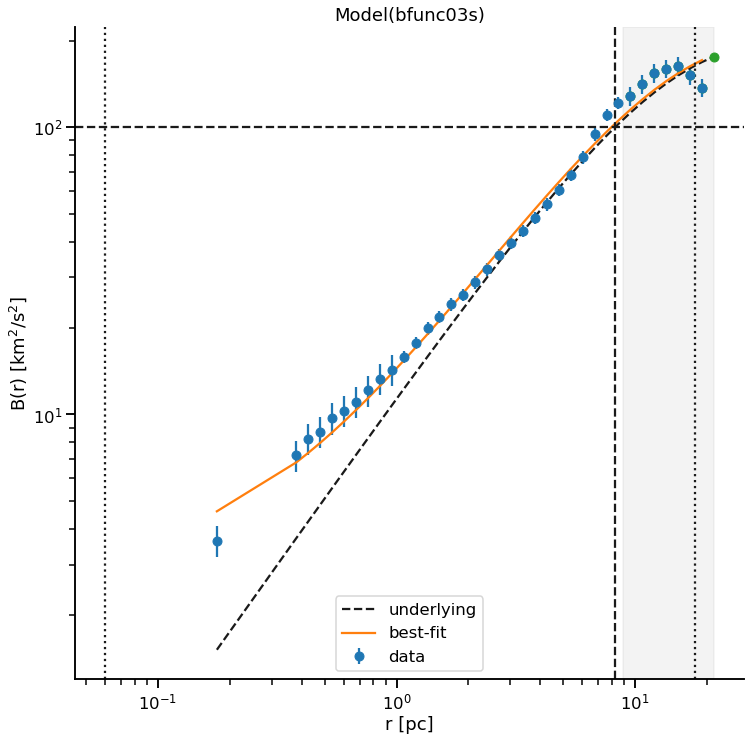

In [22]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(
    r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value
)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(box_size, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(box_size / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale="log",
    yscale="log",
    xlabel="r [pc]",
    ylabel=r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine()

emcee

In [23]:
emcee_kws = dict(
    steps=50000, burn=500, thin=50, is_weighted=True, progress=False, workers=16
)
emcee_params = result.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [24]:
result_emcee = model.fit(
    data=B[to_fit],
    r=r[to_fit],
    weights=weights[to_fit],
    params=emcee_params,
    method="emcee",
    nan_policy="omit",
    fit_kws=emcee_kws,
)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [25]:
result_emcee

Text(0, 0.5, 'acceptance fraction')

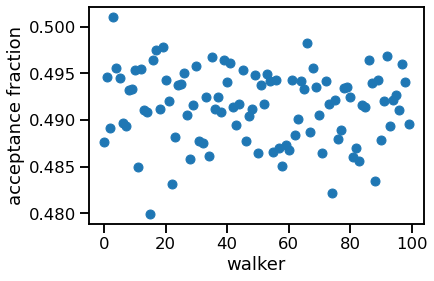

In [26]:
plt.plot(result_emcee.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")

In [27]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee.params):
        try:
            print(f"{p} = {result_emcee.acor[i]:.3f}")
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 140.529
sig2 = 133.918
m = 111.190
s0 = 81.700
noise = 84.410


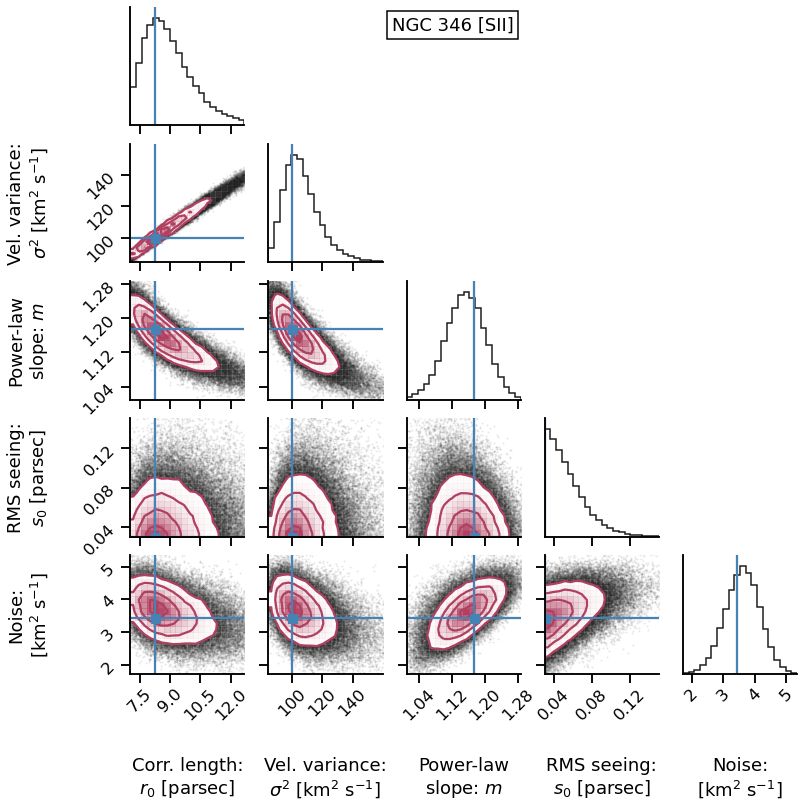

In [28]:
bplot.corner_plot(
    result_emcee, result, name, data, data_ranges=[0.95, 0.99, 0.995, 0.997, 0.999]
)
# data_ranges=[0.95, 0.99, 0.995, 0.995, 0.999]

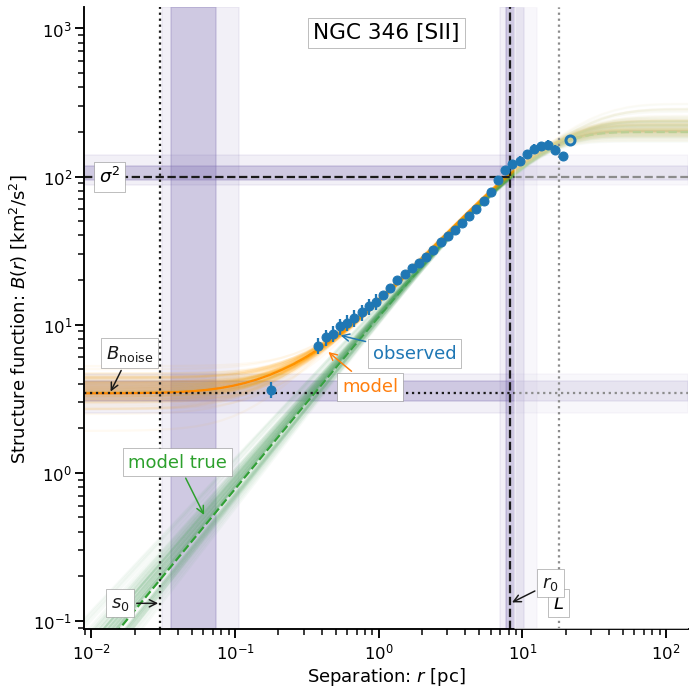

In [29]:
bplot.strucfunc_plot(
    result_emcee, result, r, B, to_fit, name, data, box_size, large_scale
)

In [30]:
#bplot.strucfunc_plot(
#    result_emcee, result_emcee, r, B, to_fit, name, data, box_size, large_scale
#)

LM results

In [31]:
LM = {
    'sig2': [result.params['sig2'].value,result.params['sig2'].stderr],
    'r0': [result.params['r0'].value,result.params['r0'].stderr],
    'm' : [result.params['m'].value,result.params['m'].stderr],
    's0': [result.params['s0'].value,result.params['s0'].stderr],
    'noise' : [result.params['noise'].value,result.params['noise'].stderr]
}

In [32]:
LM

{'sig2': [99.87454862161377, 14.487965482740352],
 'r0': [8.224427046887847, 1.4223295215501481],
 'm': [1.1743359277730785, 0.0645395270555416],
 's0': [0.030058448235499715, 0.030615811402316596],
 'noise': [3.4342953534132175, 7.5049481018678526]}

MCMC results

In [33]:
MCMC = {
    'sig2': [result_emcee.params['sig2'].value,result_emcee.params['sig2'].stderr],
    'r0': [result_emcee.params['r0'].value,result_emcee.params['r0'].stderr],
    'm' : [result_emcee.params['m'].value,result_emcee.params['m'].stderr],
    's0': [result_emcee.params['s0'].value,result_emcee.params['s0'].stderr],
    'noise' : [result_emcee.params['noise'].value,result_emcee.params['noise'].stderr]
}

In [34]:
MCMC

{'sig2': [104.8064034698809, 11.60864539033166],
 'r0': [8.742870837938778, 1.2631094718577187],
 'm': [1.1530889270533609, 0.04806204982145157],
 's0': [0.04979916053255956, 0.019031071303045058],
 'noise': [3.6261524490758408, 0.5468790533339534]}

MCMC 2 sigma confidence interval

In [35]:
sig2s2 = np.percentile(result_emcee.flatchain['sig2'],[2.5, 97.5])
r0s2 = np.percentile(result_emcee.flatchain['r0'],[2.5, 97.5])
ms2 = np.percentile(result_emcee.flatchain['m'],[2.5, 97.5])
s0s2 = np.percentile(result_emcee.flatchain['s0'],[2.5, 97.5])
b0s2 = np.percentile(result_emcee.flatchain['noise'],[2.5, 97.5])

In [36]:
sig2s2p = sig2s2[1]-result.params['sig2'].value
sig2s2m = result.params['sig2'].value-sig2s2[0]

r0s2p = r0s2[1]-result.params['r0'].value
r0s2m = result.params['r0'].value-r0s2[0]

ms2p = ms2[1]-result.params['m'].value
ms2m = result.params['m'].value-ms2[0]

s0s2p = s0s2[1]-result.params['s0'].value
s0s2m = result.params['s0'].value-s0s2[0]

b0s2p = b0s2[1]-result.params['noise'].value
b0s2m = result.params['noise'].value-b0s2[0]

MCMC 1 sigma confidence interval

In [37]:
sig2s1 = np.percentile(result_emcee.flatchain['sig2'],[16, 85])
r0s1 = np.percentile(result_emcee.flatchain['r0'],[16, 85])
ms1 = np.percentile(result_emcee.flatchain['m'],[16, 85])
s0s1 = np.percentile(result_emcee.flatchain['s0'],[16, 85])
b0s1 = np.percentile(result_emcee.flatchain['noise'],[16, 85])

In [38]:
sig2s1p = sig2s1[1]-result.params['sig2'].value
sig2s1m = result.params['sig2'].value-sig2s1[0]

r0s1p = r0s1[1]-result.params['r0'].value
r0s1m = result.params['r0'].value-r0s1[0]

ms1p = ms1[1]-result.params['m'].value
ms1m = result.params['m'].value-ms1[0]

s0s1p = s0s1[1]-result.params['s0'].value
s0s1m = result.params['s0'].value-s0s1[0]

b0s1p = b0s1[1]-result.params['noise'].value
b0s1m = result.params['noise'].value-b0s1[0]

LM + MCMC 2 sigma

In [39]:
results_2sig = {
    'sig2': [result.params['sig2'].value,sig2s2p,sig2s2m],
    'r0': [result.params['r0'].value,r0s2p,r0s2m],
    'm' : [result.params['m'].value,ms2p,ms2m],
    's0': [result.params['s0'].value,s0s2p,s0s2m],
    'noise' : [result.params['noise'].value,b0s2p,b0s2m] 
    
}

In [40]:
results_2sig

{'sig2': [99.87454862161377, 39.0033980693118, 11.790869016074666],
 'r0': [8.224427046887847, 4.46070768868468, 1.2099168077502735],
 'm': [1.1743359277730785, 0.07146838242066011, 0.11942519217092196],
 's0': [0.030058448235499715, 0.07551757872077601, -0.0008613570527879928],
 'noise': [3.4342953534132175, 1.2257580696029766, 0.9164940254428919]}

In [41]:
results_1sig = {
    'sig2': [result.params['sig2'].value,sig2s1p,sig2s1m],
    'r0': [result.params['r0'].value,r0s1p,r0s1m],
    'm' : [result.params['m'].value,ms1p,ms1m],
    's0': [result.params['s0'].value,s0s1p,s0s1m],
    'noise' : [result.params['noise'].value,b0s1p,b0s1m] 
    
}

In [42]:
results_1sig

{'sig2': [99.87454862161377, 19.064691732453767, 4.676600432263598],
 'r0': [8.224427046887847, 2.093278842394856, 0.49466665534344756],
 'm': [1.1743359277730785, 0.02821339092401054, 0.06930996728967154],
 's0': [0.030058448235499715, 0.04472202520018856, -0.0056123373205726225],
 'noise': [3.4342953534132175, 0.7462719278601773, 0.3630223492146132]}

Previous SF results and obs

In [43]:
observations ={
    'sb':data_in['VF']['sb'],
    'vv':data_in['VF']['vv'],
    'ss':data_in['VF']['ss']
    
}

In [44]:
properties = {
    'pix' : data_in['pix'],
    'pc' : data_in['pc'],
    'box_size' : data_in['box_size']
}

In [45]:
fit_results = {
    'name' : name_in,
    'results_1sig' : results_1sig,
    'results_2sig' : results_2sig,
    'LM':LM,
    'MCMC':MCMC,
    'properties' : properties,
    'B' : B,
    'r' : r,
     'preres' : data_in['results'],
     'SFresults' : data_in['SF'],
    'observations' : observations
    
}

In [46]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [47]:
jsonfilename =name_in +".json"
with open(datapath_res/jsonfilename, "w") as f:
    json.dump(fit_results, fp=f, indent=3, cls=MyEncoder)

In [48]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 439.95095682144165 seconds ---


In [49]:
!jupyter nbconvert --to script --no-prompt ci-MUSE-N346-S-downsample.ipynb

[NbConvertApp] Converting notebook ci-MUSE-N346-S-downsample.ipynb to script
[NbConvertApp] Writing 8725 bytes to ci-MUSE-N346-S-downsample.py
